In [ ]:
# === Setup & Imports ===
import os, itertools, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Output directories
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [ ]:
# === Utility helpers ===
def plot_confusion(cm, classes, title, save_path=None):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def compute_metrics(y_true, y_pred, average='weighted'):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

In [ ]:
# === Load Datasets ===
iris = datasets.load_iris()


datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.967 | Precision: 0.970 | Recall: 0.967 | F1: 0.9666
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



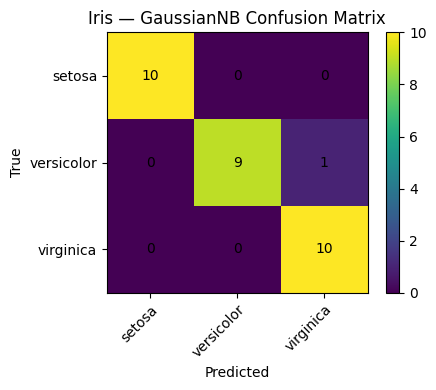


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.833 | Precision: 0.835 | Recall: 0.833 | F1: 0.8329
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.78      0.70      0.74        10
   virginica       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



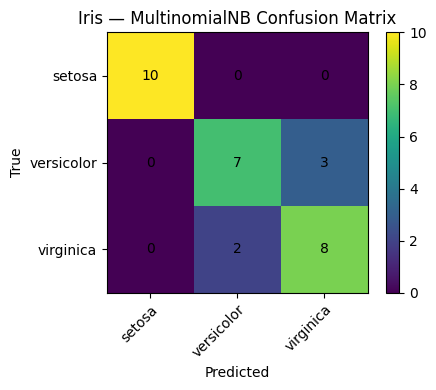


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.4}
Test Accuracy: 0.733 | Precision: 0.819 | Recall: 0.733 | F1: 0.6706
              precision    recall  f1-score   support

      setosa       0.83      1.00      0.91        10
  versicolor       1.00      0.20      0.33        10
   virginica       0.62      1.00      0.77        10

    accuracy                           0.73        30
   macro avg       0.82      0.73      0.67        30
weighted avg       0.82      0.73      0.67        30



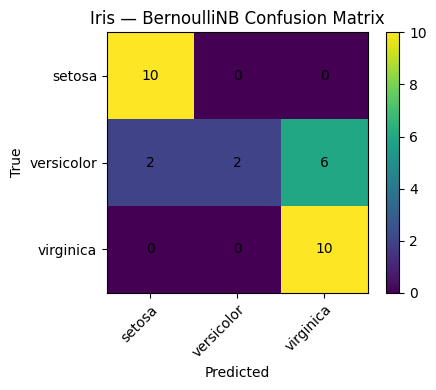


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.966667,0.969697,0.966667,0.966583
1,Iris,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.833333,0.835017,0.833333,0.832916
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.4}",0.733333,0.819444,0.733333,0.670552


In [ ]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[Iris] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__splitter': 'best'}
Test Accuracy: 0.967 | Precision: 0.970 | Recall: 0.967 | F1: 0.967


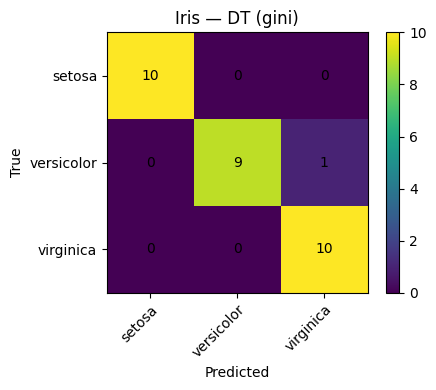

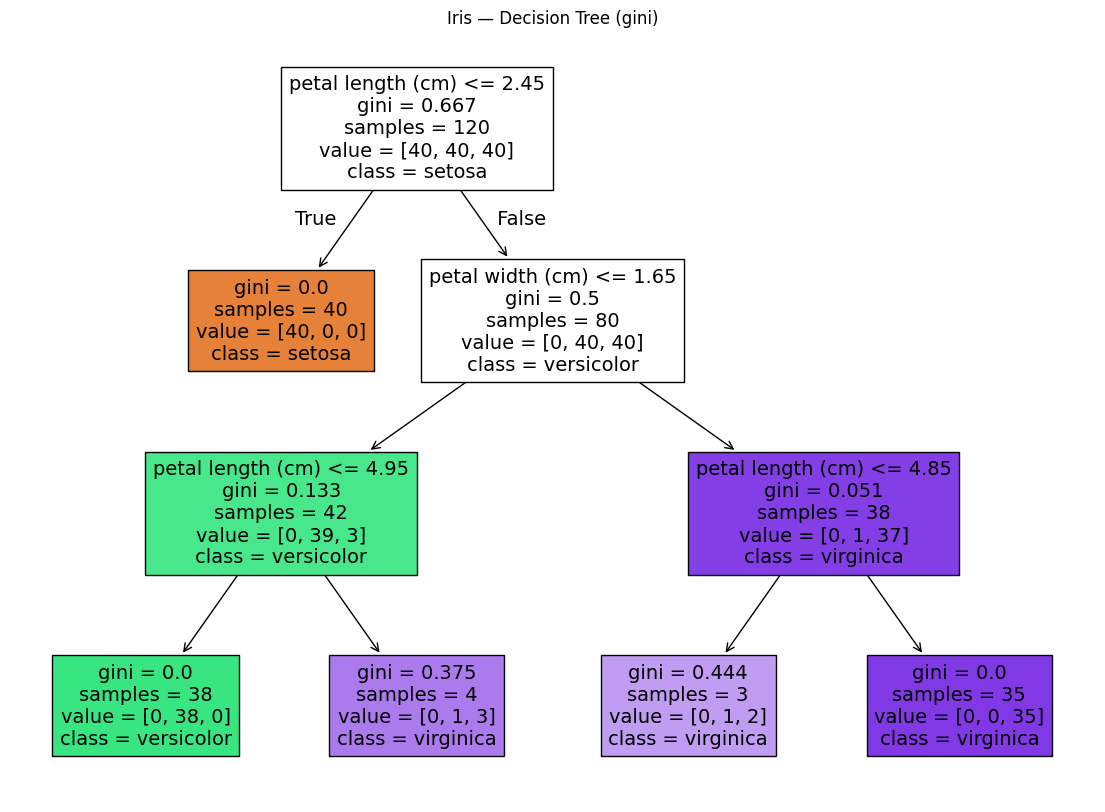

[Iris] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__splitter': 'random'}
Test Accuracy: 0.933 | Precision: 0.933 | Recall: 0.933 | F1: 0.933


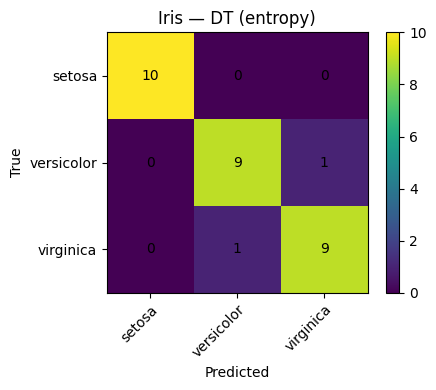

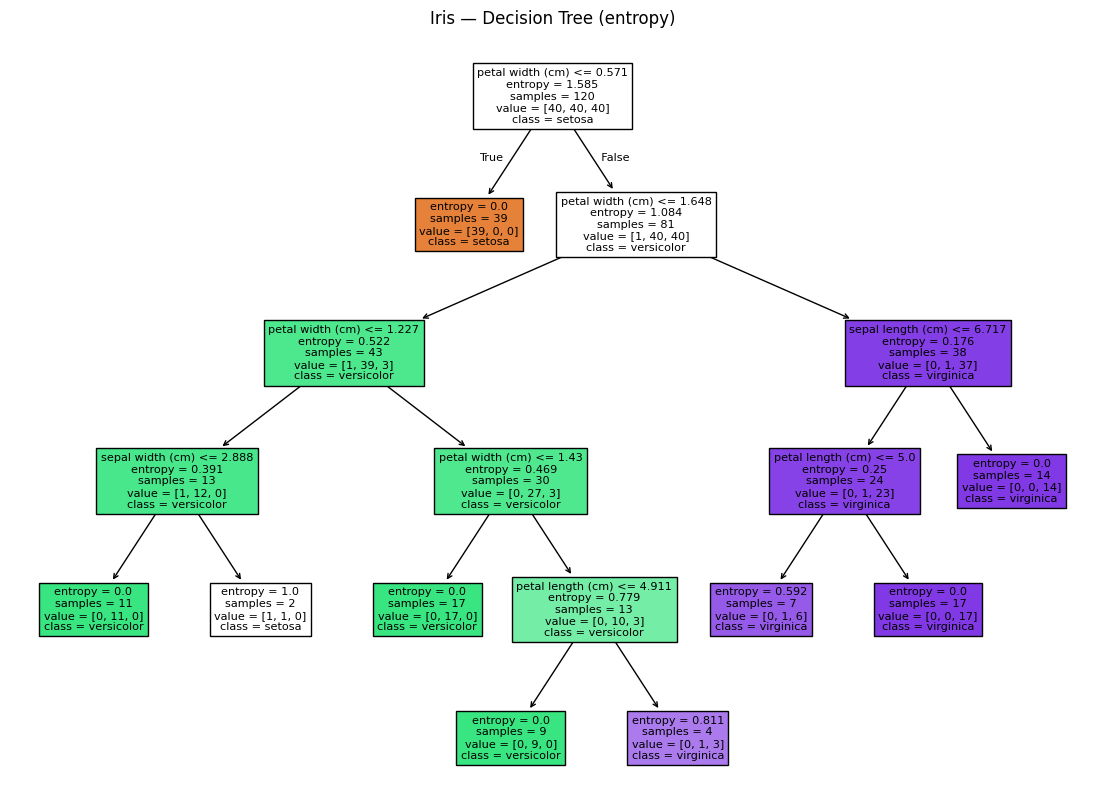


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,Iris,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.966667,0.969697,0.966667,0.966583,outputs/Iris/DecisionTree/Gini/Iris_DT_gini_tr...
1,Iris,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.933333,0.933333,0.933333,0.933333,outputs/Iris/DecisionTree/Entropy/Iris_DT_entr...


In [ ]:
# === Decision Trees (Gini & Entropy, images saved) ===

def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)

    # Plot and save tree image
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results

In [ ]:
# === Load Datasets ===
BC = datasets.load_breast_cancer()


datasets_map = {
    "breast_cancer": (BC.data, BC.target, BC.feature_names, BC.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['breast_cancer']



[breast_cancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.937 | Precision: 0.937 | Recall: 0.937 | F1: 0.9363
              precision    recall  f1-score   support

   malignant       0.95      0.88      0.91       106
      benign       0.93      0.97      0.95       179

    accuracy                           0.94       285
   macro avg       0.94      0.92      0.93       285
weighted avg       0.94      0.94      0.94       285



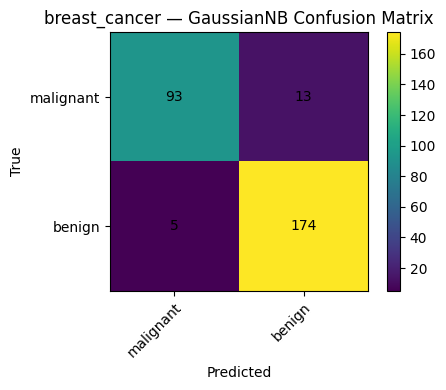


[breast_cancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 1.0, 'clf__fit_prior': True}
Test Accuracy: 0.853 | Precision: 0.873 | Recall: 0.853 | F1: 0.8436
              precision    recall  f1-score   support

   malignant       0.97      0.62      0.76       106
      benign       0.82      0.99      0.89       179

    accuracy                           0.85       285
   macro avg       0.89      0.81      0.83       285
weighted avg       0.87      0.85      0.84       285



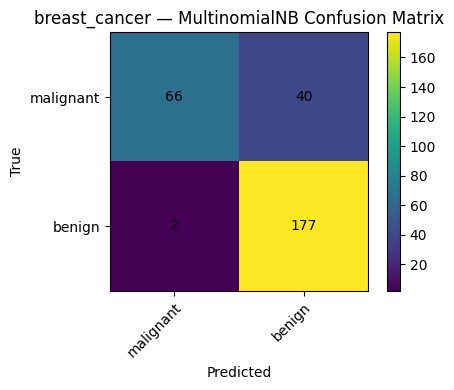


[breast_cancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.5, 'clf__binarize': 0.4}
Test Accuracy: 0.940 | Precision: 0.942 | Recall: 0.940 | F1: 0.9396
              precision    recall  f1-score   support

   malignant       0.97      0.87      0.92       106
      benign       0.93      0.98      0.95       179

    accuracy                           0.94       285
   macro avg       0.95      0.93      0.93       285
weighted avg       0.94      0.94      0.94       285



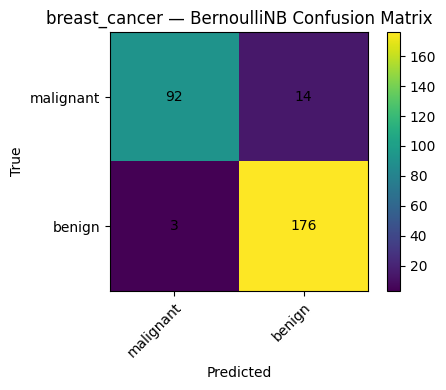


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,breast_cancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.936842,0.937361,0.936842,0.936294
1,breast_cancer,MultinomialNB,"{'clf__alpha': 1.0, 'clf__fit_prior': True}",0.852632,0.873288,0.852632,0.843610
2,breast_cancer,BernoulliNB,"{'clf__alpha': 0.5, 'clf__binarize': 0.4}",0.940351,0.941976,0.940351,0.939608


In [ ]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[breast_cancer] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__splitter': 'random'}
Test Accuracy: 0.944 | Precision: 0.944 | Recall: 0.944 | F1: 0.944


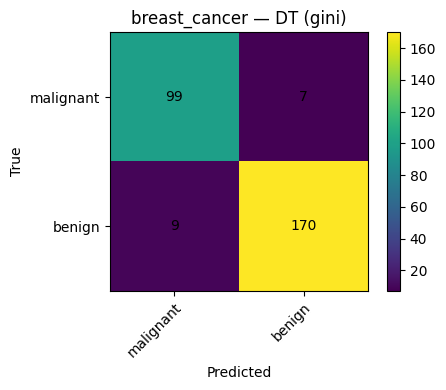

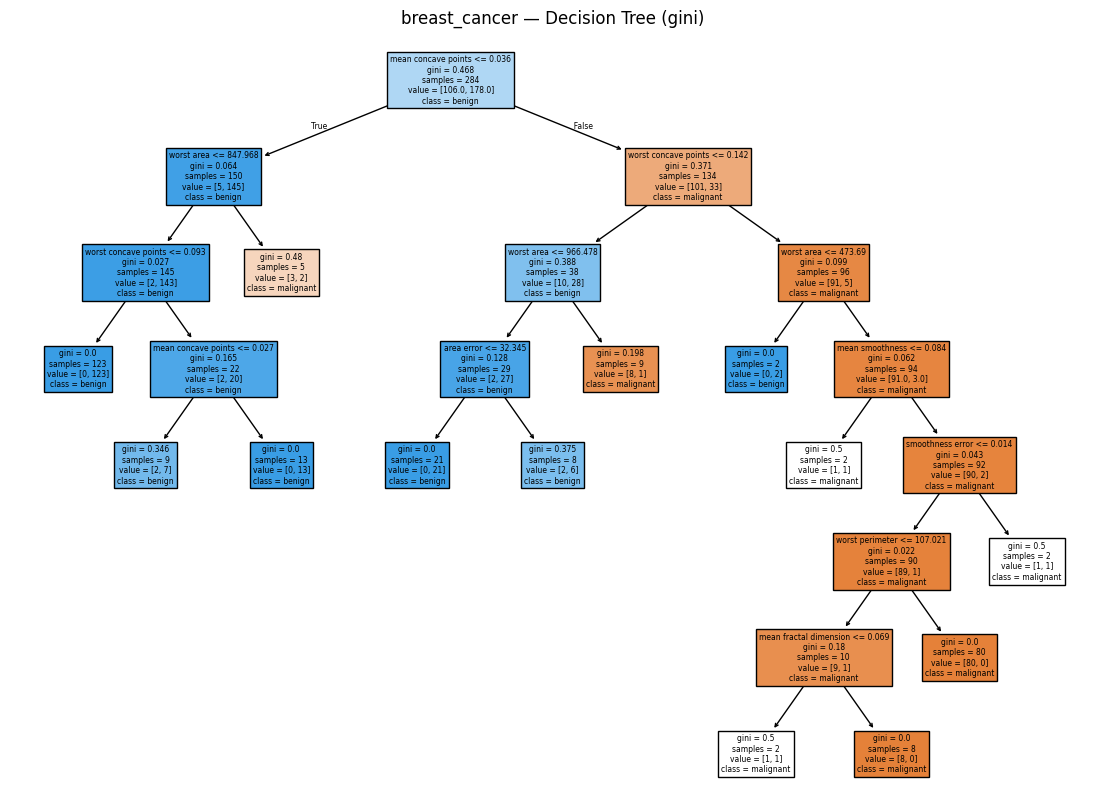

[breast_cancer] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
Test Accuracy: 0.909 | Precision: 0.911 | Recall: 0.909 | F1: 0.909


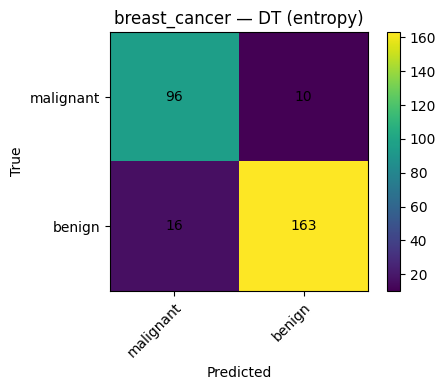

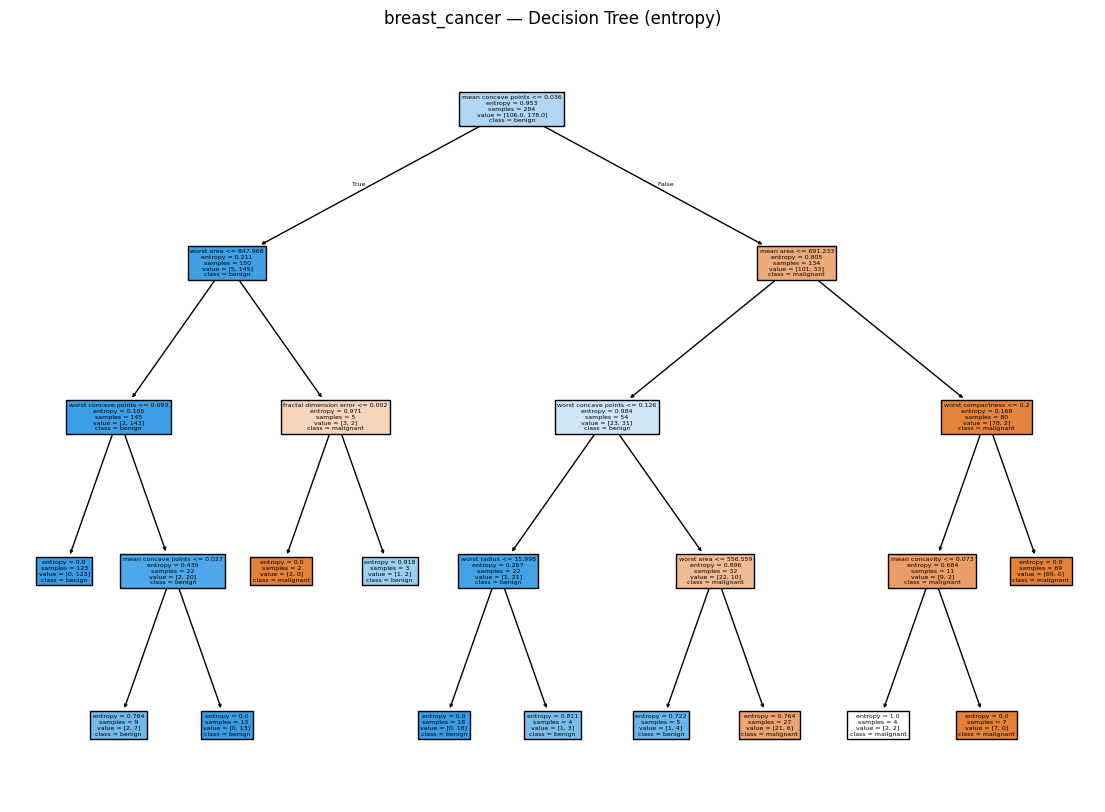


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,breast_cancer,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.943860,0.944167,0.943860,0.943964,outputs/breast_cancer/DecisionTree/Gini/breast...
1,breast_cancer,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.908772,0.910563,0.908772,0.909250,outputs/breast_cancer/DecisionTree/Entropy/bre...


In [ ]:
# === Decision Trees (Gini & Entropy, images saved) ===

def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)

    # Plot and save tree image
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results

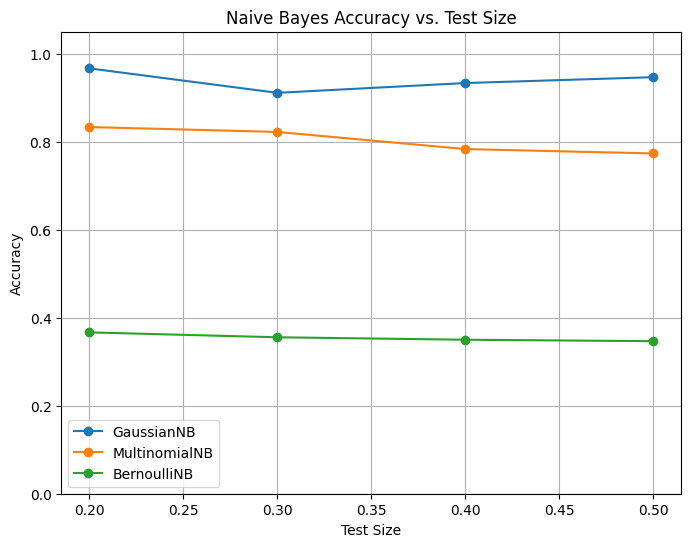

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load the Iris dataset (you can replace with your own)
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Define the test sizes to evaluate
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Set up models in pipelines
models = {
    "GaussianNB": Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())]),
    "MultinomialNB": Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())]),
    "BernoulliNB": Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
}

# Dictionary to store accuracies
results = {name: [] for name in models.keys()}

RANDOM_STATE = 42  # fixed seed for reproducibility

for ts in test_sizes:
    for name, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=ts, stratify=y, random_state=RANDOM_STATE
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)

# Plotting the results
plt.figure(figsize=(8, 6))
for name, accs in results.items():
    plt.plot(test_sizes, accs, marker='o', label=name)

plt.title("Naive Bayes Accuracy vs. Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()
